In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [5]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

# IPMI 2023 FEM box experiment

In [6]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023'

In [7]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{pde_name}'

# define the parameter space

fem_box_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)
fem_box_space2 = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['hetero2'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)

param_space = fem_box_space2
len(param_space)

6

In [8]:
%autoreload

expt_name = '2022-11-23_fem_box_init'
#expt_name = '2022-11-26_fem_box_hetero2'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [9]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs)[status_cols]
status

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
13256772,train_fem_box_50_helmholtz,NaN,NaN,NaN,v020.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256773,train_fem_box_50_hetero,NaN,NaN,NaN,v020.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256774,train_fem_box_60_helmholtz,NaN,NaN,NaN,v024.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256775,train_fem_box_60_hetero,NaN,NaN,NaN,v016.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256776,train_fem_box_70_helmholtz,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256777,train_fem_box_70_hetero,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256778,train_fem_box_80_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256779,train_fem_box_80_hetero,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13256780,train_fem_box_90_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n


In [10]:
print(status.iloc[0].stderr[-100:])

Using backend: pytorch




In [11]:
metrics = ps.metrics(jobs)

# did all models train to completion?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

u_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 50         all                   all                0.000106   
                                           1                       NaN   
                                           2                       NaN   
                                           3                       NaN   
                                           4                       NaN   
...                                                                ...   
hetero    100        6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            u_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 50         all                   all             9.598885e-09   
                                           1                        NaN   
                                           2                        NaN   
                                           3                        NaN   
                                           4                        NaN   
...                                                                 ...   
hetero    100        6.0                   all                      NaN   
                     7.0                   all                      NaN   
                     8.0                   all                      NaN   
                     9.0                   all                      NaN   
                     10.0                  all                      NaN   

                                                           u_true_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 50         all                   all                0.000107   
                                           1                       NaN   
                                           2                       NaN   
                                           3                       NaN   
                                           4                       NaN   
...                                                                ...   
hetero    100        6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            lu_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                  
helmholtz 50         all                   all             112807.467742   
                                           1                         NaN   
                                           2                         NaN   
                                           3                         NaN   
                                           4                         NaN   
...                                                                  ...   
hetero    100        6.0                   all                       NaN   
                     7.0                   all                       NaN   
                     8.0                   all                       NaN   
                     9.0                   all                       NaN   
                     10.0                  all                       NaN   

                                                           lu_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 50      

<IPython.core.display.Javascript object>


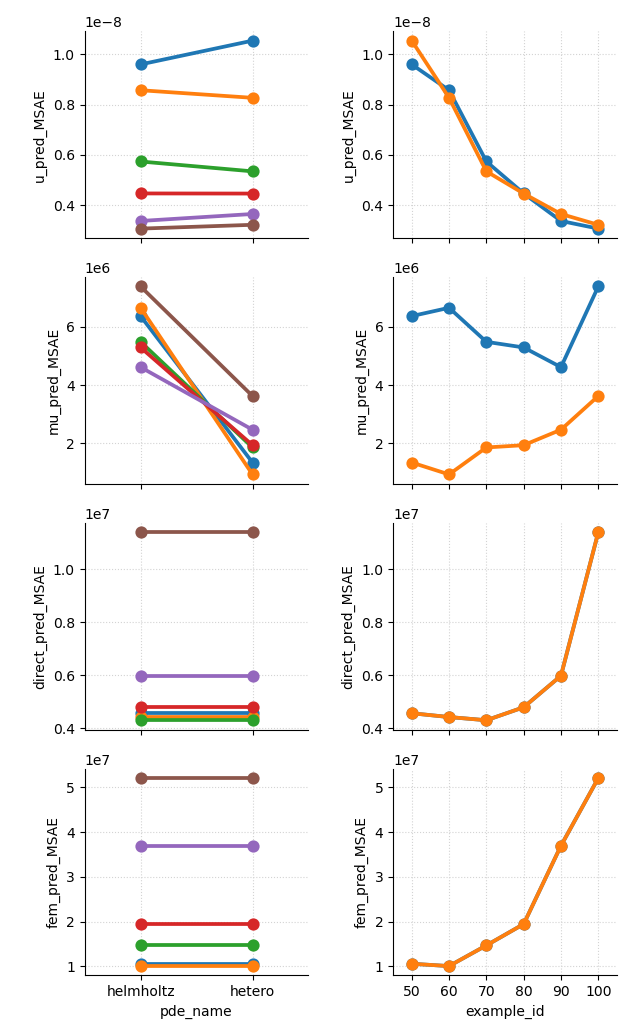

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.a

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.a

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))

  boot_dist.append(f(*sample, **func_kwargs))



In [12]:
m = metrics.reset_index()

fig = ps.plot(
    m[m.spatial_region == 'all'],
    x=param_cols,
    y=['u_pred_MSAE', 'mu_pred_MSAE', 'direct_pred_MSAE', 'fem_pred_MSAE'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [13]:
m['method'] = 'PINN_' + m['pde_name']

direct_m = m.copy()
direct_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_m[col.replace('direct', 'mu')] = m[col]

fem_m = m.copy()
fem_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_m, fem_m, m])

In [38]:
mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV']
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV']

In [52]:
import seaborn as sns

sns.set_palette('Blues')
sns.color_palette()

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


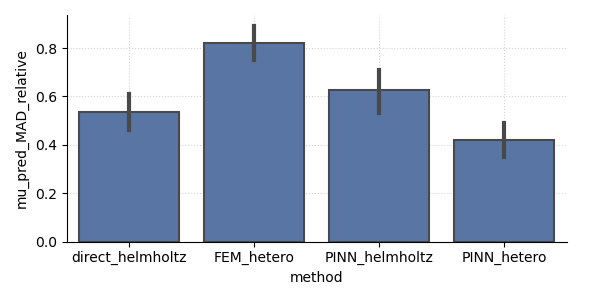

In [69]:
sns.set_palette('deep')

fig = ps.plot(
    mm[mm.spatial_region != 'all'],
    x='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=6,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)

<IPython.core.display.Javascript object>


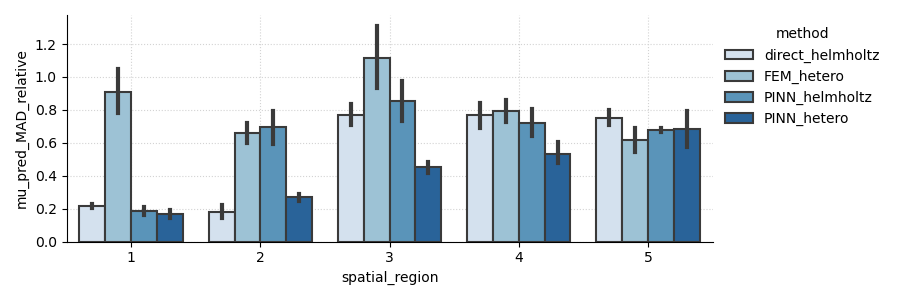

In [75]:
sns.set_palette('Blues', 4)

fig = ps.plot(
    mm[~mm.spatial_region.isin({'0', 'all'})],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)

<IPython.core.display.Javascript object>


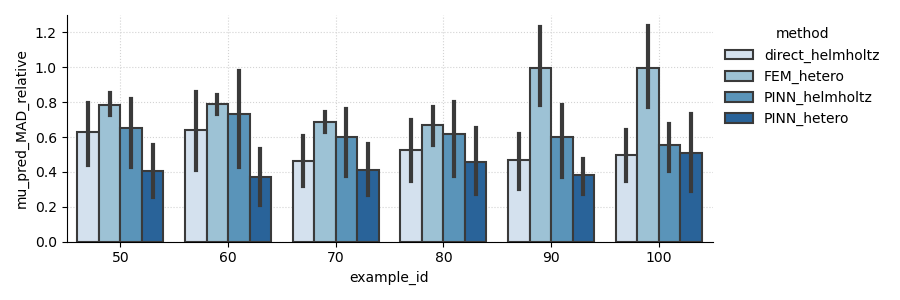

In [76]:
sns.set_palette('Blues', 4)

fig = ps.plot(
    mm[~mm.spatial_region.isin({'0', 'all'})],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)